# Dual-form ridge and online training of line attractor

Statistics: error vs num support states and integration window

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, Lasso
import sys

from aux import get_flow
from kernels import make_psi_rand_sgm
from disp import set_plot, colors, quiver

In [2]:
# hparams
D = 2
RX = np.linspace(-1.5, 1.5, 15)
DX = np.mean(np.diff(RX))/2

# base system params
TAU = np.array(.01)
B = np.eye(D)
f_base = lambda x: np.zeros(D)
F_base = lambda x, u: (1/TAU)*(-x + f_base(x) + B@u)

DT = .001

# control directions
C = np.array([
    [1., 0],
    [0,  1],
])  #L   U

# kernel
N = 2000
G = 100
J_PSI = G*np.random.randn(N, D)

psi_name = 'rand_sig'
psi, ker = make_psi_rand_sgm(J_PSI)

def ker_vmap(xs, y):
    k_mat = np.nan*np.zeros((len(xs),))
    for cx, x in enumerate(xs):
        k_mat[cx] = ker(x, y)
    return k_mat

def eval_F(x, u, x_stars, alphas):
    
    df = C@alphas.T@ker_vmap(x_stars, x)
    
    return (1/TAU)*(-x + f_base(x) + B@u + df)
    
def smlt_trj(x_stars, alphas, x_init, t, us):

    dt = np.mean(np.diff(t))
    xs = np.nan*np.zeros((len(t), D))
    xs[0, :] = x_init

    for ct, t_ in enumerate(t[1:], 1):
        dx = dt*eval_F(xs[ct-1, :], us[ct, :], x_stars, alphas)
        xs[ct, :] = xs[ct-1, :] + dx

    return xs

def eval_F_primal(x, u, W):
    
    df = C@W.T@psi(x)
    
    return (1/TAU)*(-x + f_base(x) + B@u + df)
    
def smlt_trj_primal(W, x_init, t, us):

    dt = np.mean(np.diff(t))
    xs = np.nan*np.zeros((len(t), D))
    xs[0, :] = x_init

    for ct, t_ in enumerate(t[1:], 1):
        dx = dt*eval_F_primal(xs[ct-1, :], us[ct, :], W)
        xs[ct, :] = xs[ct-1, :] + dx

    return xs

Ridge training

In [3]:
LAM_RIDGE = 1e-10

def train_ridge(data, x_stars):
    """Find alphas using Ridge regression."""
    xs = data[:, :D]
    vs = data[:, D:2*D]
    us = data[:, 2*D:]
    
    # make ys
    f_base_vals = np.array([f_base(x) for x in xs])
    Bus = np.array([B@u for u in us])
    
    ys = TAU*vs + xs - f_base_vals - Bus
    
    # make K
    K = np.array([ker_vmap(xs, x_star) for x_star in x_stars]).T
    
    # find best alphas
    rgr = Ridge(alpha=LAM_RIDGE, fit_intercept=False)
    alphas = rgr.fit(K, ys).coef_.T
    return alphas

Online training

In [4]:
LAM_ONLINE = 1000

T_START = 0.01
IT_START = int(T_START//DT)

T_HOLD = .1
IT_HOLD = int(T_HOLD//DT)

T_PAUSE = .1
IT_PAUSE = int(T_PAUSE//DT)

def train_online(x_stars, alphas):
    
    t_learn = np.arange(0, (len(x_stars)+1)*(T_HOLD+T_PAUSE), DT)
    us_learn = np.zeros((len(t_learn), D))
    ls = np.zeros((len(t_learn), D))

    it_temp = IT_START

    for cx_star, (x_star, alpha) in enumerate(zip(x_stars, alphas)):
        us_learn[it_temp:it_temp+IT_HOLD, :] = LAM_ONLINE*x_star
        ls[it_temp+IT_HOLD-1, :] = 1/DT*alpha

        it_temp += (IT_HOLD + IT_PAUSE)

    W = np.zeros((N, D))

    xs = np.nan*np.zeros((len(t_learn), D))
    xs[0, :] = np.zeros(D)

    for ct, t_ in enumerate(t_learn[1:], 1):
        dx = DT*eval_F_primal(xs[ct-1, :], us_learn[ct, :], W)
        xs[ct, :] = xs[ct-1, :] + dx

        # implement plasticity rule
        if np.linalg.norm(ls[ct]) > 0:
            for d in range(D):
                W[:, d] += (DT*ls[ct, d]*psi(xs[ct, :]))
    
    return W

In [5]:
def plot_quivers_primal(eval_F_primal, u=None):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
    
    F_primal = lambda x, u: eval_F_primal(x, u, W)
    flow = get_flow(F_primal, RX, u=u)
    
    quiver(axs[0], flow, RX)
    set_plot(axs[0], x_label=r'$x_1$', y_label=r'$x_2$')

    return fig, axs

def plot_quivers(x_stars_all, alphas_all, u=None, arrow_scale=.5, s=10):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
    flow_base = get_flow(F_base, RX, u=u)
    quiver(axs[0], flow_base, RX)
    set_plot(axs[0], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{base}$')

    F_PRE = lambda x, u: eval_F(x, u, x_stars_all[0], alphas_all[0])
    flow_pre = get_flow(F_PRE, RX, u=u)
    quiver(axs[1], flow_pre, RX)
    
    for x_star, alpha in zip(x_stars_all[0], alphas_all[0]):
        axs[1].scatter(*x_star, c='r', s=s)
        axs[1].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[1], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{pre}$')

    F_POST = lambda x, u: eval_F(x, u, x_stars_all[-1], alphas_all[-1])
    flow_post = get_flow(F_POST, RX, u=u)
    quiver(axs[2], flow_post, RX)
    
    for x_star, alpha in zip(x_stars_all[-1], alphas_all[-1]):
        axs[2].scatter(*x_star, c='r', s=s)
        axs[2].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[2], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{post}$')

    quiver(axs[3], flow_post-flow_base, RX)
    
    for x_star, alpha in zip(x_stars_all[-1], alphas_all[-1]):
        axs[3].scatter(*x_star, c='r', s=s)
        axs[3].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[3], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\Delta \mathbf{f}$')

    return fig, axs

Target flow (zero at specific locations)

In [6]:
n_tilde = 96

x_tildes = np.array([np.linspace(-1.5, 1.5, n_tilde), np.ones(n_tilde)]).T
v_tildes = np.zeros((n_tilde, D))

u_tildes = np.zeros((n_tilde, D))
u_tildes[:, 1] = 1

data = np.concatenate([x_tildes, v_tildes, u_tildes], axis=1)

In [7]:
# support states
n_star = 11
x_stars = np.array([
    np.linspace(-1.5, 1.5, n_star),
    np.ones(n_star),
]).T

# ridge training
alphas = train_ridge(data, x_stars)

irnd = np.random.permutation(len(x_stars))
x_stars = x_stars[irnd, :]
alphas = alphas[irnd, :]

F_POST = lambda x, u: eval_F(x, u, x_stars, alphas)

# online training
W = train_online(x_stars, alphas)

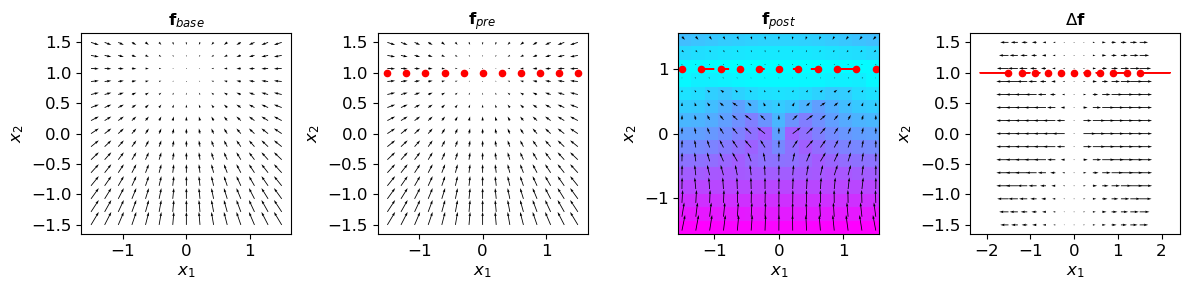

In [8]:
# plot flow fields
x_stars_all = [x_stars, x_stars]
alphas_all = [0*alphas, alphas]
fig, axs = plot_quivers(x_stars_all, alphas_all, arrow_scale=.15, u=np.array([0., 1]), s=20)

flow_post = get_flow(F_POST, RX, u=np.array([0., 1]))
extent = [RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2]
axs[2].matshow(np.sqrt(flow_post[:, :, 0]**2 + flow_post[:, :, 1]**2).T, origin='lower', extent=extent, cmap='cool')
axs[2].xaxis.tick_bottom()

fig.savefig('ms/s2_line_attr_flow_ridge.svg')

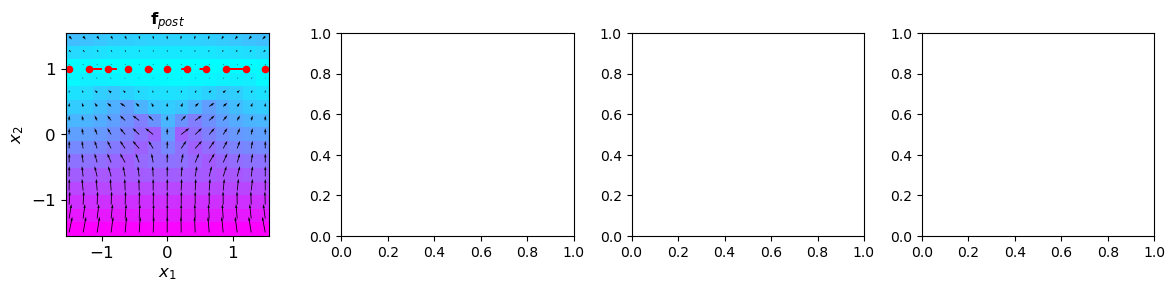

In [9]:
# online-trained flow fields
fig, axs = plot_quivers_primal(eval_F_primal, u=np.array([0., 1]))

# support states added
arrow_scale=.15
for x_star, alpha in zip(x_stars_all[-1], alphas_all[-1]):
    axs[0].scatter(*x_star, c='r', s=20)
    axs[0].arrow(*x_star, *alpha*arrow_scale, color='r')
set_plot(axs[0], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{post}$')

F_POST = lambda x, u: eval_F_primal(x, u, W)
flow_post = get_flow(F_POST, RX, u=np.array([0., 1]))
extent = [RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2]
axs[0].matshow(np.sqrt(flow_post[:, :, 0]**2 + flow_post[:, :, 1]**2).T, origin='lower', extent=extent, cmap='cool')
axs[0].xaxis.tick_bottom()

fig.savefig('ms/3_line_attr_flow_online.svg')

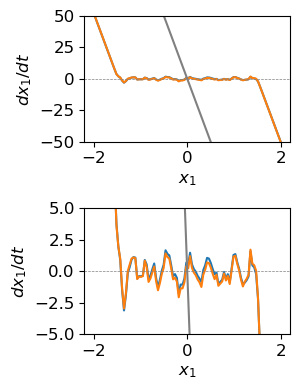

In [10]:
# plot flow fields along the line x_2=1
F_BASE = lambda x, u: eval_F_primal(x, u, 0*W)
F_RIDGE = lambda x, u: eval_F(x, u, x_stars, alphas)
F_ONLINE = lambda x, u: eval_F_primal(x, u, W)

rx_1 = np.linspace(-2., 2., 100)
u_test = np.array([0, 1.])
dxdt_base = [F_BASE(np.array([x_1_, 1]), u_test)[0] for x_1_ in rx_1]
dxdt_ridge = [F_RIDGE(np.array([x_1_, 1]), u_test)[0] for x_1_ in rx_1]
dxdt_online = [F_ONLINE(np.array([x_1_, 1]), u_test)[0] for x_1_ in rx_1]

fig, axs = plt.subplots(2, 1, figsize=(3.1, 4), tight_layout=True)
for ax in axs:
    ax.plot(rx_1, dxdt_ridge)
    ax.plot(rx_1, dxdt_online)
    ax.plot(rx_1, dxdt_base, c='gray')
    ax.axhline(0, color='gray', ls='--', lw=.5)
set_plot(axs[0], y_lim=(-50., 50.), x_label=r'$x_1$', y_label=r'$dx_1/dt$')
set_plot(axs[1], y_lim=(-5., 5.), x_label=r'$x_1$', y_label=r'$dx_1/dt$')

fig.savefig('ms/3_line_attr_flow_fields_1d.svg')

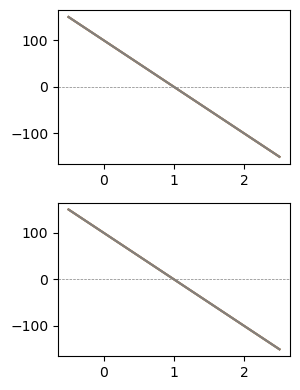

In [11]:
# plot flow fields along lines x_2=0 and x_2=1
rx_2 = np.linspace(-.5, 2.5, 100)
u_test = np.array([0, 1.])

fig, axs = plt.subplots(2, 1, figsize=(3.1, 4), tight_layout=True)
for x_1_, ax in zip([0, 1], axs):
    dxdt_base = [F_BASE(np.array([x_1_, x_2_]), u_test)[1] for x_2_ in rx_2]
    dxdt_ridge = [F_RIDGE(np.array([x_1_, x_2_]), u_test)[1] for x_2_ in rx_2]
    dxdt_online = [F_ONLINE(np.array([x_1_, x_2_]), u_test)[1] for x_2_ in rx_2]
    ax.plot(rx_2, dxdt_ridge)
    ax.plot(rx_2, dxdt_online)
    ax.plot(rx_2, dxdt_base, c='gray')
    ax.axhline(0, color='gray', ls='--', lw=.5)

fig.savefig('ms/3s_line_attr_flow_fields_1d_x_2=1.svg')

In [12]:
## integrate task
t = np.arange(0, .5, .001)

us = np.zeros((len(t), D))
us[:, 1] = 1
us[:, 0] = .5*np.random.randn(len(t))

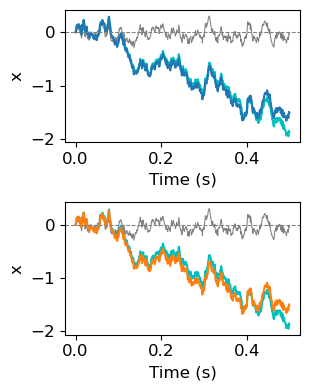

In [13]:
x_int_ideal = np.cumsum(us[:, 0])*DT/TAU

x_init = np.array([0, 1.])
xs_0_ridge = smlt_trj(x_stars, 0*alphas, x_init, t, us)
xs_ridge = smlt_trj(x_stars, alphas, x_init, t, us)

xs_0_online = smlt_trj_primal(0*W, x_init, t, us)
xs_online = smlt_trj_primal(W, x_init, t, us)

fig, axs = plt.subplots(2, 1, figsize=(3.2, 4.0), tight_layout=True, sharey=True)
axs[0].plot(t, xs_0_ridge[:, 0], c='gray', lw=.75)
axs[0].plot(t, xs_ridge[:, 0], c=colors[0])

axs[1].plot(t, xs_0_online[:, 0], c='gray', lw=.75)
axs[1].plot(t, xs_online[:, 0], c=colors[1])

for ax in axs:
    ax.plot(t, x_int_ideal, c='c', zorder=-1)
    ax.axhline(0, color='gray', ls='--', lw=.75)
    set_plot(ax, x_label='Time (s)', y_label='x')

fig.savefig('ms/3_line_attr_int_demo_ridge_online.svg')

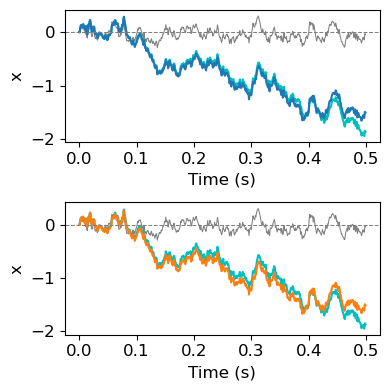

In [14]:
x_int_ideal = np.cumsum(us[:, 0])*DT/TAU

x_init = np.array([0, 1.])
xs_0_ridge = smlt_trj(x_stars, 0*alphas, x_init, t, us)
xs_ridge = smlt_trj(x_stars, alphas, x_init, t, us)

xs_0_online = smlt_trj_primal(0*W, x_init, t, us)
xs_online = smlt_trj_primal(W, x_init, t, us)

fig, axs = plt.subplots(2, 1, figsize=(4, 4.0), tight_layout=True, sharey=True)
axs[0].plot(t, xs_0_ridge[:, 0], c='gray', lw=.75)
axs[0].plot(t, xs_ridge[:, 0], c=colors[0])

axs[1].plot(t, xs_0_online[:, 0], c='gray', lw=.75)
axs[1].plot(t, xs_online[:, 0], c=colors[1])

for ax in axs:
    ax.plot(t, x_int_ideal, c='c', zorder=-1)
    ax.axhline(0, color='gray', ls='--', lw=.75)
    set_plot(ax, x_label='Time (s)', y_label='x')

fig.savefig('ms/s2_line_attr_int_demo_ridge_online.svg')

In [15]:
## integrate task
t = np.arange(0, .5, .001)

us = np.zeros((len(t), D))
us[:, 1] = 1
us[:, 0] = .05*np.random.randn(len(t))

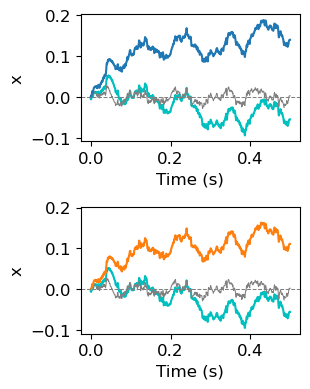

In [16]:
x_int_ideal = np.cumsum(us[:, 0])*DT/TAU

x_init = np.array([0, 1.])
xs_0_ridge = smlt_trj(x_stars, 0*alphas, x_init, t, us)
xs_ridge = smlt_trj(x_stars, alphas, x_init, t, us)

xs_0_online = smlt_trj_primal(0*W, x_init, t, us)
xs_online = smlt_trj_primal(W, x_init, t, us)

fig, axs = plt.subplots(2, 1, figsize=(3.2, 4.0), tight_layout=True, sharey=True)
axs[0].plot(t, xs_0_ridge[:, 0], c='gray', lw=.75)
axs[0].plot(t, xs_ridge[:, 0], c=colors[0])

axs[1].plot(t, xs_0_online[:, 0], c='gray', lw=.75)
axs[1].plot(t, xs_online[:, 0], c=colors[1])

for ax in axs:
    ax.plot(t, x_int_ideal, c='c', zorder=-1)
    ax.axhline(0, color='gray', ls='--', lw=.75)
    set_plot(ax, x_label='Time (s)', y_label='x')
    
fig.savefig('ms/s3_line_attr_small_u_sd.svg')

In [19]:
## integrate task
t = np.arange(0, .5, .001)

us = np.zeros((len(t), D))
us[:, 1] = 1
us[:, 0] = 2.*np.random.randn(len(t))

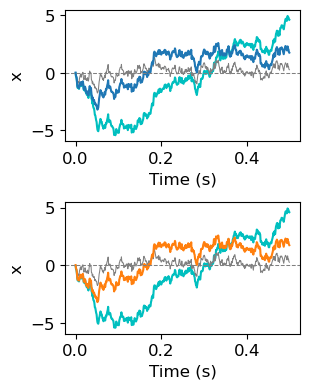

In [20]:
x_int_ideal = np.cumsum(us[:, 0])*DT/TAU

x_init = np.array([0, 1.])
xs_0_ridge = smlt_trj(x_stars, 0*alphas, x_init, t, us)
xs_ridge = smlt_trj(x_stars, alphas, x_init, t, us)

xs_0_online = smlt_trj_primal(0*W, x_init, t, us)
xs_online = smlt_trj_primal(W, x_init, t, us)

fig, axs = plt.subplots(2, 1, figsize=(3.2, 4.0), tight_layout=True, sharey=True)
axs[0].plot(t, xs_0_ridge[:, 0], c='gray', lw=.75)
axs[0].plot(t, xs_ridge[:, 0], c=colors[0])

axs[1].plot(t, xs_0_online[:, 0], c='gray', lw=.75)
axs[1].plot(t, xs_online[:, 0], c=colors[1])

for ax in axs:
    ax.plot(t, x_int_ideal, c='c', zorder=-1)
    ax.axhline(0, color='gray', ls='--', lw=.75)
    set_plot(ax, x_label='Time (s)', y_label='x')
    
fig.savefig('ms/s3_line_attr_int_large_u_sd.svg')